# Get started

## Get forest cover change from TMF

The function `.get_fcc()` can be used to download forest cover change from the Tropical Moist Forest product. We will use the Reunion Island (isocode "REU") as a case study.

In [1]:
import os

import ee
import geefcc
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches
import cartopy.crs as ccrs
import rioxarray

In [2]:
# Initialize GEE
ee.Initialize(project="forestatrisk", opt_url="https://earthengine-highvolume.googleapis.com")

In [3]:
# Download data from GEE
if not os.path.isfile("out_tmf/forest_tmf.tif"):
    geefcc.get_fcc(
        aoi="REU",
        years=[2000, 2010, 2020],
        source="tmf",
        tile_size=0.5,
        output_file="out_tmf/forest_tmf.tif",
    )

In [4]:
# Load data
forest_tmf = rioxarray.open_rasterio("out_tmf/forest_tmf.tif")
forest_tmf

<xarray.DataArray (band: 3, y: 1923, x: 2305)> Size: 13MB
[13297545 values with dtype=int8]
Coordinates:
  * band         (band) int64 24B 1 2 3
  * x            (x) float64 18kB 55.22 55.22 55.22 55.22 ... 55.84 55.84 55.84
  * y            (y) float64 15kB -20.87 -20.87 -20.87 ... -21.39 -21.39 -21.39
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0

In [5]:
# Computing the sum
fcc_tmf = forest_tmf.sum(dim="band")
fcc_tmf

<xarray.DataArray (y: 1923, x: 2305)> Size: 35MB
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])
Coordinates:
  * x            (x) float64 18kB 55.22 55.22 55.22 55.22 ... 55.84 55.84 55.84
  * y            (y) float64 15kB -20.87 -20.87 -20.87 ... -21.39 -21.39 -21.39
    spatial_ref  int64 8B 0

In [6]:
# Colors
cols=[(255, 165, 0, 255), (227, 26, 28, 255), (34, 139, 34, 255)]
colors = [(1, 1, 1, 0)]  # transparent white for 0
cmax = 255.0  # float for division
for col in cols:
    col_class = tuple([i / cmax for i in col])
    colors.append(col_class)
color_map = ListedColormap(colors)

# Labels
labels = {0: "non-forest in 2000", 1:"deforestation 2000-2009", 2:"deforestation 2010-2019", 3:"forest in 2020"}
patches =[mpatches.Patch(facecolor=col, edgecolor="black", label=labels[i]) for (i, col) in enumerate(colors)]

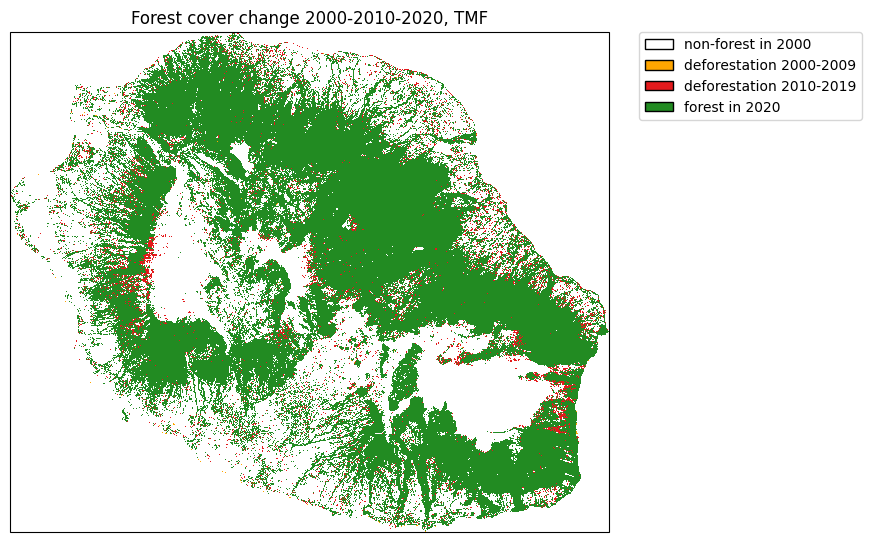

In [7]:
# Plot
fig = plt.figure(figsize=[7, 5])
ax = fig.add_axes([0, 0, 1, 1], projection=ccrs.PlateCarree())
raster_image = fcc_tmf.plot(ax=ax, cmap=color_map, add_colorbar=False)
plt.title("Forest cover change 2000-2010-2020, TMF")
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

## Compare with forest cover change from GFC

In [8]:
# Get data from GEE
if not os.path.isfile("out_gfc_50/forest_gfc_50.tif"):
    geefcc.get_fcc(
        aoi="REU",
        years=[2001, 2010, 2020],  # Here, first year must be 2001 (1st Jan)
        source="gfc",
        perc=50,
        tile_size=0.5,
        output_file="out_gfc_50/forest_gfc_50.tif",
    )

In [9]:
# Load data
forest_gfc = rioxarray.open_rasterio("out_gfc_50/forest_gfc_50.tif")
fcc_gfc = forest_gfc.sum(dim="band")

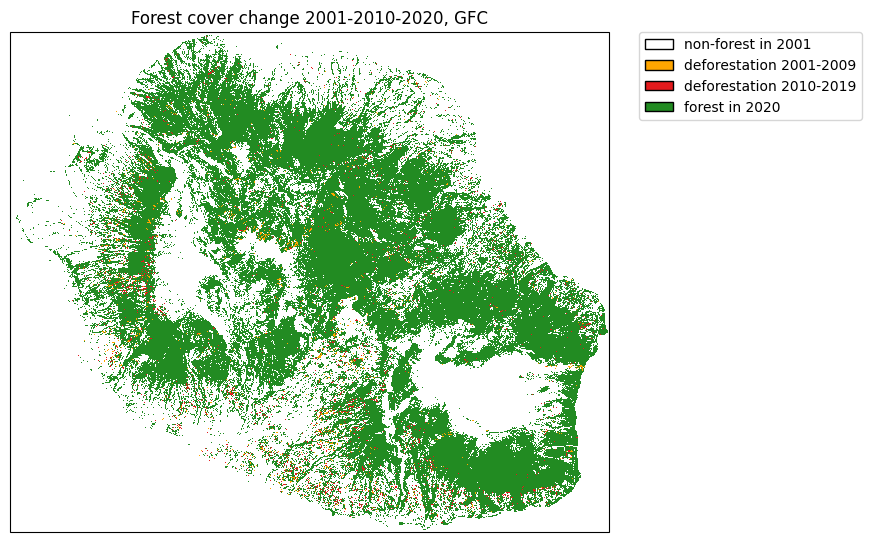

In [10]:
# Plot
fig = plt.figure(figsize=[7, 5])
ax = fig.add_axes([0, 0, 1, 1], projection=ccrs.PlateCarree())
raster_image = fcc_gfc.plot(ax=ax, cmap=color_map, add_colorbar=False)
plt.title("Forest cover change 2001-2010-2020, GFC")
labels = {0: "non-forest in 2001", 1:"deforestation 2001-2009", 2:"deforestation 2010-2019", 3:"forest in 2020"}
patches =[mpatches.Patch(facecolor=col, edgecolor="black", label=labels[i]) for (i, col) in enumerate(colors)]
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

## Comparing forest cover in 2020 between TMF and GFC

In [11]:
# Computing difference and sum
forest_diff = forest_tmf.sel(band=3) - forest_gfc.sel(band=3)
forest_sum = forest_tmf.sel(band=3) + forest_gfc.sel(band=3)
forest_diff = forest_diff.where(forest_sum != 0, -2)

In [12]:
# Colors
cols=[(10, 10, 150, 255), (34, 139, 34, 255), (200, 200, 0, 255)]
colors = [(1, 1, 1, 0)]  # transparent white for -2
cmax = 255.0  # float for division
for col in cols:
    col_class = tuple([i / cmax for i in col])
    colors.append(col_class)
color_map = ListedColormap(colors)

In [13]:
# Labels
labels = {0: "non-forest tmf, non-forest gfc", 1:"non-forest tmf / forest gfc",
          2:"forest tmf / forest gfc", 3:"forest tmf, non-forest gfc"}
patches =[mpatches.Patch(facecolor=col, edgecolor="black", label=labels[i]) for (i, col) in enumerate(colors)]

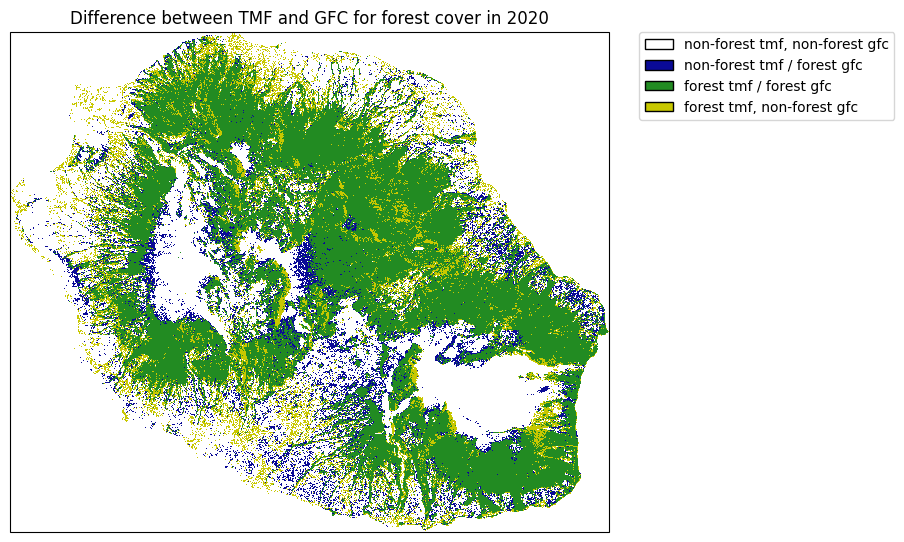

In [14]:
# Plot
fig = plt.figure(figsize=[7, 5])
ax = fig.add_axes([0, 0, 1, 1], projection=ccrs.PlateCarree())
raster_image = forest_diff.plot(ax=ax, cmap=color_map, add_colorbar=False)
plt.title("Difference between TMF and GFC for forest cover in 2020")
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

Differences are quite important between the two data-sets. This might change depending on the tree cover threshold (here = 75%) we select for defining forest with the GFC dataset.

## Download data from an extent

We will use the following extent which corresponds to a region around the Analamazaotra special reserve in Madagascar.

In [15]:
if not os.path.isfile("out_tmf_extent/forest_tmf_extent.tif"):
    geefcc.get_fcc(
        aoi=(48.4, -19.0, 48.6, -18.8),
        years=[2000, 2010, 2020],
        source="tmf",
        tile_size=0.2,
        output_file="out_tmf_extent/forest_tmf_extent.tif",
    )

In [16]:
# Load data
forest_tmf_mdg = rioxarray.open_rasterio("out_tmf_extent/forest_tmf_extent.tif")
fcc_tmf_mdg = forest_tmf_mdg.sum(dim="band")

In [17]:
# Colors
cols=[(255, 165, 0, 255), (227, 26, 28, 255), (34, 139, 34, 255)]
colors = [(1, 1, 1, 0)]  # transparent white for 0
cmax = 255.0  # float for division
for col in cols:
    col_class = tuple([i / cmax for i in col])
    colors.append(col_class)
color_map = ListedColormap(colors)

# Labels
labels = {0: "non-forest in 2000", 1:"deforestation 2000-2009", 2:"deforestation 2010-2019", 3:"forest in 2020"}
patches =[mpatches.Patch(facecolor=col, edgecolor="black", label=labels[i]) for (i, col) in enumerate(colors)]

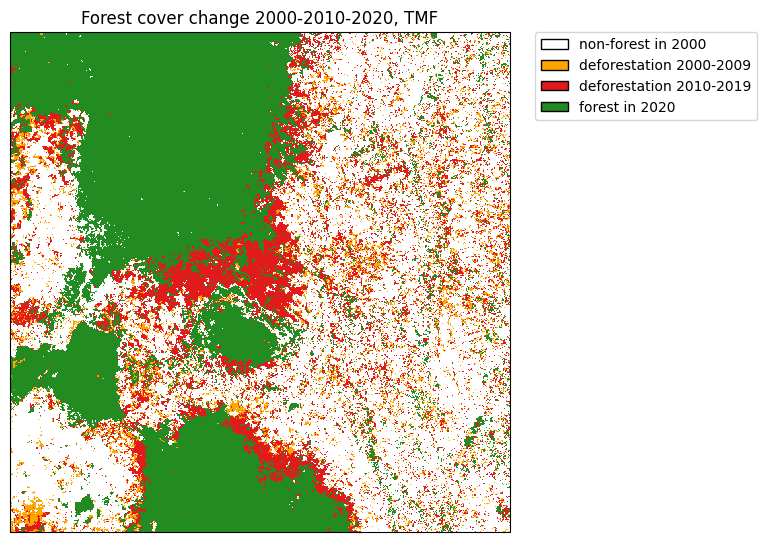

In [18]:
# Plot
fig = plt.figure(figsize=[7, 5])
ax = fig.add_axes([0, 0, 1, 1], projection=ccrs.PlateCarree())
raster_image = fcc_tmf_mdg.plot(ax=ax, cmap=color_map, add_colorbar=False)
plt.title("Forest cover change 2000-2010-2020, TMF")
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()